# Prediction of COVID-19 Around the World

| Student | __Angela Amador__ |
| ------ | ----- |
| TMU Student Number | __500259095__ |
| Supervisor | __Tamer Abdou, PhD__  |

I aim to demonstrate how Machine Learning (ML) models are able to predict the spread of COVID-19 around the world.

First, I will explore the dataset to get insights and better understand patterns, detect error and outliers, and find relationships between variables.

Then I will evaluate prediction models and evaluate their fitness.

## Preparation

The dataset is taken from Our World in Data website, officially collected by Our World in Data team: https://covid.ourworldindata.org/data/owid-covid-data.csv.

The dataset, provides COVID-19 information collected by [Our World in Data](https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset) and made available by the Kaggle community https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset/download?datasetVersionNumber=418. This dataset is updated daily.

In [134]:
import warnings

# Use jupyter_black to automatically format the code
import black
import jupyter_black
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

# Import libraries
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from ydata_profiling import ProfileReport


jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="INFO",
    target_version=black.TargetVersion.PY310,
)

# Use pycodestyle to enforce coding standards.
%load_ext pycodestyle_magic
%pycodestyle_on

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"

# Seeding the pseudo random number generator with a specific value
# makes results predictable and reproducible
np.random.seed(873409)

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


## Helper Functions

In [135]:
def df_details(title, dfs):
    """ Generate a markdown table with details of a dataframe """

    output = f"| {'' if title is None else title} |"
    for label, df in dfs.items():
        output += f" {label} |"

    output += "\n| :--- |" + " ---: |" * len(dfs)

    output += "\n| Number of observations |"
    for label, df in dfs.items():
        output += f" {df.shape[0]} |"

    output += "\n| Number of attributes |"
    for label, df in dfs.items():
        output += f" {df.shape[1]} |"

    output += "\n| Size |"
    for label, df in dfs.items():
        output += f" {df.size} |"

    display(Markdown(output))


def describe_nan(df):
    "Produce a summary count of nan counts in dataframe"
    return pd.DataFrame(
        [
            (
                i,
                df[df[i].isna()].shape[0],
                df[df[i].isna()].shape[0] / df.shape[0]
            )
            for i in df.columns
        ],
        columns=["column", "nan_count", "nan_rate"],
    )


def show_items_in_table(label, items_list, n_cols=8):
    """"Shows a list of elements in table format for easier inspection"""
    output = "" + ("" if label is None else label) + "\n"
    output += "|" + " |" * n_cols + "\n"
    output += "|" + " :--- |" * n_cols + "\n"
    row = 0
    while (row * n_cols < len(items_list)):
        output += "|" + \
            " | ".join([
                f"`{x}`" for x in items_list[row*n_cols:(row+1)*n_cols]
                ])
        if (row+1)*n_cols > len(items_list):
            output += \
                " |" * (
                    1 if (len(items_list) % n_cols) == 0
                    else n_cols - (len(items_list) % n_cols) + 1
                    ) + "\n"
        else:
            output += " |" + "\n"
        row += 1
    display(Markdown(output))


def nan_density_plot(_df, plotsize=(16, 8)):
    """ Groups the values in each row of the dataframe by week,
    counts how many there are in each week, and generates a violin
    plot to allow exploring the occurrence of NaNs in the dataframe
    through time    """
    df = _df.copy()
    df = df.\
        isna().\
        groupby(
            df.index - df.index.weekday * np.timedelta64(1, 'D'),
            sort=False
        ).\
        sum().\
        reset_index()
    df.set_index("date", inplace=True)
    tsum = df.sum(axis=0)
    column_labels = (f"{i} [{tsum[i]}]" for i in tsum.index)

    # describe_nan(raw_data).sort_values(by="nan_rate", ascending=False).query(
    #     "nan_rate >= 0"
    # )
    # sum(df["continent"])
    # sum(df["people_fully_vaccinated_per_hundred"])

    fontsize = 10
    fig, axes = plt.subplots(figsize=plotsize)
    axes.violinplot(df,
                    showextrema=False,
                    vert=True
                    )

    axes.set_title('NaN density over time for the features in the dataset')
    axes.xaxis.grid(True)
    axes.set_xlabel('Dataset Feature')
    axes.set_ylabel('Date')
    # axes.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes.get_yaxis().set_visible(False)
    axes.set_xticks(
        [x + 1 for x in range(len(df.columns))],
        labels=column_labels
    )
    plt.xticks(rotation=90)
    # plt.yticks(df.index, rotation=90)

    return plt.show()

## Load file and explore data

For the purpose of this study I'm analyzing the data with information up to Oct 7th, 2023.

In [136]:
# Load file
raw_data = pd.read_csv("archive.zip", sep=",")

# Set the appropriate data type for the date column and
# use it as index for the dataframe.
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.set_index('date', inplace=True)

display(Markdown("> Explore the data as loaded from the source:"))
raw_data.head()

display(Markdown(f"""
> The dataset has a total of **{raw_data["total_cases"].isna().sum()}**
observations with NaN values for the `total_cases` column.<br>As this
will be my predicted feature, NaN values don't add value to the
model so I'll remove them.
"""))
raw_data_before = raw_data
raw_data = raw_data[raw_data["total_cases"].notna()]
df_details("Removing observations with NaN in `total_cases`", {
    "Before": raw_data_before,
    "After": raw_data
    }
)

# Int32 supports NaN values, but as there no longer are NaN values for
# the total_cases feature I can set the data type to int32.
raw_data["total_cases"] = raw_data["total_cases"].astype('int32')

> Explore the data as loaded from the source:

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-04,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-05,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-06,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-07,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN



> The dataset has a total of **37895**
observations with NaN values for the `total_cases` column.<br>As this
will be my predicted feature, NaN values don't add value to the
model so I'll remove them.


| Removing observations with NaN in `total_cases` | Before | After |
| :--- | ---: | ---: |
| Number of observations | 346567 | 308672 |
| Number of attributes | 66 | 66 |
| Size | 22873422 | 20372352 |

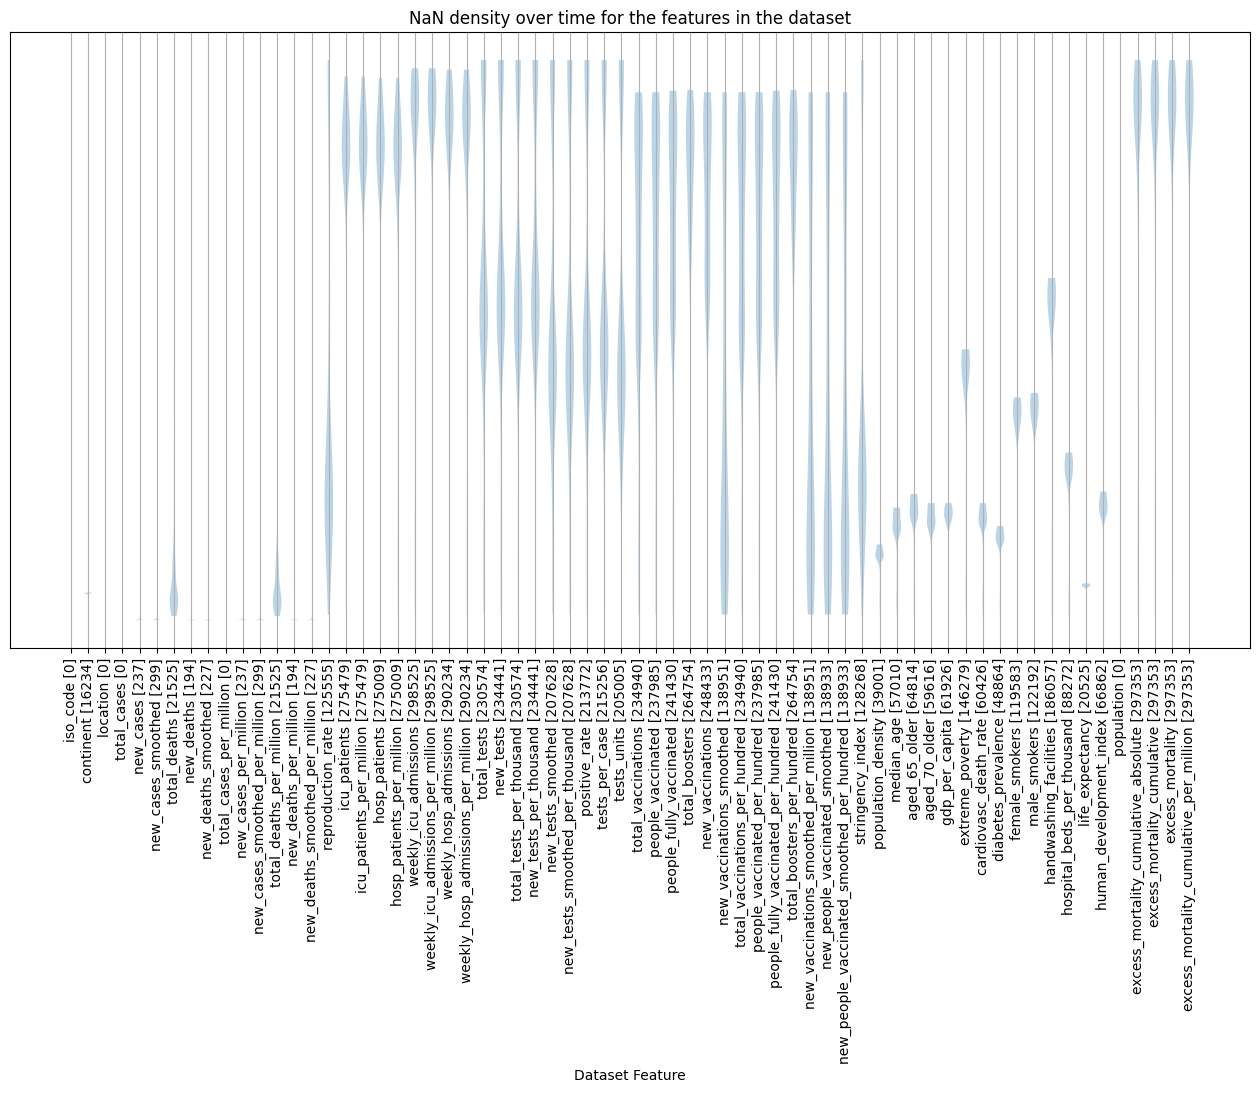

In [137]:
nan_density_plot(raw_data)

Due to the large number of different values for the `iso_code` and `location` features, I need to make a decision of droping information outside Noth America.

The original dataset had 346,567 observations and 67 attributes. Without this subsetting, after applying One Hot Encoding, we are left with 552 attributes.

In [138]:
raw_data_before = raw_data

raw_data = raw_data[raw_data["continent"].isin(["North America"])]
# raw_data.drop(raw_data[raw_data.location in [
#     "Canada",
#     "United States",
#     "Mexico"
# ]].index)

df_details("Remove observations from outside North America",
           {
               "Before": raw_data_before,
               "After": raw_data,
            })

| Remove observations from outside North America | Before | After |
| :--- | ---: | ---: |
| Number of observations | 308672 | 53290 |
| Number of attributes | 66 | 66 |
| Size | 20372352 | 3517140 |

### Check the data type and metadata of the attributes

Look at meta information about data, such as data types and null values.

In [139]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53290 entries, 2020-03-27 to 2023-10-04
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    53290 non-null  object 
 1   continent                                   53290 non-null  object 
 2   location                                    53290 non-null  object 
 3   total_cases                                 53290 non-null  int32  
 4   new_cases                                   53141 non-null  float64
 5   new_cases_smoothed                          53136 non-null  float64
 6   total_deaths                                48572 non-null  float64
 7   new_deaths                                  53141 non-null  float64
 8   new_deaths_smoothed                         53141 non-null  float64
 9   total_cases_per_million                     53290 non-null  float6

Look at meta information about numeric data, we can also see if there any
extreme values.

In [140]:
raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cases,53290.0,1.678567e+06,1.067253e+07,1.0000,2185.500000,1.219700e+04,1.349345e+05,1.034368e+08
new_cases,53141.0,2.342684e+03,2.293665e+04,0.0000,0.000000,0.000000e+00,5.500000e+01,1.265520e+06
new_cases_smoothed,53136.0,2.342901e+03,2.104200e+04,0.0000,0.143000,8.000000e+00,1.150000e+02,8.097353e+05
total_deaths,48572.0,2.841419e+04,1.377650e+05,1.0000,30.000000,1.880000e+02,3.124000e+03,1.127152e+06
new_deaths,53141.0,3.022214e+01,2.086185e+02,0.0000,0.000000,0.000000e+00,0.000000e+00,5.061000e+03
new_deaths_smoothed,53141.0,3.020267e+01,1.921759e+02,0.0000,0.000000,0.000000e+00,1.143000e+00,3.407857e+03
total_cases_per_million,53290.0,1.142590e+05,1.406548e+05,0.0030,5366.823500,5.525618e+04,1.711241e+05,6.267931e+05
new_cases_per_million,53141.0,1.786219e+02,1.219778e+03,0.0000,0.000000,0.000000e+00,5.609900e+01,9.804588e+04
new_cases_smoothed_per_million,53136.0,1.786276e+02,5.608156e+02,0.0000,0.452000,2.608500e+01,1.319900e+02,1.444350e+04
total_deaths_per_million,48572.0,9.656658e+02,8.355991e+02,0.0030,226.603000,7.607790e+02,1.594159e+03,3.331912e+03


### Remove data pre-dating COVID vaccine availability

Multiple vaccines became available on the second semester of 2020. By December most countries had access to approved vaccines.

As vaccinations changed the behaviour of the pandemic I will remove data before Jan 1st, 2021 and consider only data collected after vaccines became available.

In [141]:
raw_data_before = raw_data
raw_data = raw_data.\
    drop(raw_data[raw_data.index < pd.Timestamp(2021, 1, 1)].index)

df_details("Remove observations before vaccines were available on Jan 2021)",
           {
               "Before": raw_data_before,
               "After": raw_data,
            })

| Remove observations before vaccines were available on Jan 2021) | Before | After |
| :--- | ---: | ---: |
| Number of observations | 53290 | 41287 |
| Number of attributes | 66 | 66 |
| Size | 3517140 | 2724942 |

### One Hot Encoding in Machine Learning

Machine Learning models do not work with categorical data and to fit this data into the machine learning model it needs to be converted into numerical data. One technique is to use One Hot Encoding technique. One hot encoding is a technique that we use to represent categorical variables as numerical values in a machine learning model.

We have four catgorical variables in the dataset: `iso_code`, `continent`, `location` and `tests_units`.

In [142]:
print("Describe categorical variables")

print("\niso_code:")
raw_data['iso_code'].describe(include='all')

print("\ncontinent:")
raw_data['continent'].describe(include='all')

print("\nlocation:")
raw_data['location'].describe(include='all')

print("\ntests_units:")
raw_data['tests_units'].describe(include='all')

Describe categorical variables

iso_code:


count     41287
unique       41
top         AIA
freq       1007
Name: iso_code, dtype: object


continent:


count             41287
unique                1
top       North America
freq              41287
Name: continent, dtype: object


location:


count        41287
unique          41
top       Anguilla
freq          1007
Name: location, dtype: object


tests_units:


count                9029
unique                  3
top       tests performed
freq                 5551
Name: tests_units, dtype: object

#### Create New DataFrame

The `categorical_df` dataframe will contain only the selected categorical columns.

In [143]:
categorical_cols = ['iso_code', 'continent', 'location', 'tests_units']
categorical_df = raw_data[categorical_cols]
categorical_df.head()

,iso_code,continent,location,tests_units
date,,,,
2021-01-01,AIA,North America,Anguilla,NaN
2021-01-02,AIA,North America,Anguilla,NaN
2021-01-03,AIA,North America,Anguilla,NaN
2021-01-04,AIA,North America,Anguilla,NaN
2021-01-05,AIA,North America,Anguilla,NaN


#### Finding Unique Values

Number of unique values for the categorical features:

In [144]:
output = f"""| Feature | Number of unique values |\n| :--- | ---: |\n"""
for x in categorical_df.columns:
    output += f"| {x} | {len(categorical_df[x].unique())} |\n"
display(Markdown(output))

| Feature | Number of unique values |
| :--- | ---: |
| iso_code | 41 |
| continent | 1 |
| location | 41 |
| tests_units | 4 |


Examine how many columns we'll obtain after One Hot Encoding these variables.

In [145]:
pd.get_dummies(categorical_df, drop_first=False).shape

(41287, 86)

Apply One Hot Encoding to all 4 categorical variables: 'iso_code', 'continent', 'location' and 'tests_units'

In [146]:
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)

# One-hot encoding 'iso_code' column
origin_encoded = encoder.fit_transform(raw_data[['iso_code']])
df_encoded1 = pd.concat([
    raw_data,
    pd.DataFrame(
        origin_encoded, raw_data.index,
        columns=encoder.categories_[0])
    ], axis=1)

# If encoding iso_code created a column NaN at the end, eliminate this column
if pd.isna(df_encoded1.columns[-1]):
    df_encoded2 = df_encoded1.iloc[:, :-1]

if df_encoded1.columns.is_unique is False:
    # print('\nDuplicate columns after iso_code encoding\n')
    duplicate_cols = df_encoded1.columns[df_encoded1.columns.duplicated()]
    display(Markdown("> Duplicate columns %s are being removed." %
                     duplicate_cols))
    df_encoded1.drop(columns=duplicate_cols, inplace=True)

# One-hot encoding 'continent' column
origin_encoded = encoder.fit_transform(raw_data[['continent']])
df_encoded2 = pd.concat([
    df_encoded1,
    pd.DataFrame(
        origin_encoded, raw_data.index,
        columns=encoder.categories_[0])
    ], axis=1)

# If encoding continent created a column NaN at the end, eliminate this column
if pd.isna(df_encoded2.columns[-1]):
    df_encoded2 = df_encoded2.iloc[:, :-1]

if df_encoded2.columns.is_unique is False:
    # print('\nDuplicate columns after continent encoding\n')
    duplicate_cols = df_encoded2.columns[df_encoded2.columns.duplicated()]
    display(Markdown("> Duplicate columns %s are being removed." %
                     duplicate_cols))
    df_encoded2.drop(columns=duplicate_cols, inplace=True)

# One-hot encoding 'location' column
origin_encoded = encoder.fit_transform(df_encoded2[['location']])
df_encoded3 = pd.concat([
    df_encoded2,
    pd.DataFrame(
        origin_encoded, raw_data.index,
        columns=encoder.categories_[0])
    ], axis=1)

# If encoding location created a column NaN at the end, eliminate this column
if pd.isna(df_encoded3.columns[-1]):
    df_encoded3 = df_encoded3.iloc[:, :-1]

if df_encoded3.columns.is_unique is False:
    # print('\nDuplicate columns after location encoding\n')
    duplicate_cols = df_encoded3.columns[df_encoded3.columns.duplicated()]
    display(Markdown("> Duplicate columns %s are being removed." %
                     duplicate_cols))
    df_encoded3.drop(columns=duplicate_cols, inplace=True)

# One-hot encoding 'tests_units' column
origin_encoded = encoder.fit_transform(df_encoded3[['tests_units']])
df_encoded4 = pd.concat([
    df_encoded3,
    pd.DataFrame(
        origin_encoded, raw_data.index,
        columns=encoder.categories_[0])
    ], axis=1)

# set the max columns to none
# pd.set_option('display.max_columns', None)

# If encoding tests_units created a column NaN at the end, eliminate
# this column
if pd.isna(df_encoded4.columns[-1]):
    df_encoded4 = df_encoded4.iloc[:, :-1]

if df_encoded4.columns.is_unique is False:
    duplicate_cols = df_encoded4.columns[df_encoded4.columns.duplicated()]
    display(Markdown("> Duplicate columns %s are being removed." %
                     duplicate_cols))
    df_encoded4.drop(columns=duplicate_cols, inplace=True)

df_details("One hot encoding categorical variables:", {
    "Initially": raw_data,
    "isocode": df_encoded1,
    "continent": df_encoded2,
    "location": df_encoded3,
    "test_units": df_encoded4,
    })

display(Markdown(f"""
We have a total of {raw_data.shape[1]} columns from the original dataset
- After adding {df_encoded1.shape[1]-raw_data.shape[1]} unique
  values from iso_code, we get a total of {df_encoded1.shape[1]} columns
- After adding {df_encoded2.shape[1]-df_encoded1.shape[1]} unique
  values from continent, we get a total of {df_encoded2.shape[1]} columns
- After adding {df_encoded3.shape[1]-df_encoded2.shape[1]} unique
  values from location, we get a total of {df_encoded3.shape[1]} columns
- After adding {df_encoded4.shape[1]-df_encoded3.shape[1]} unique
  values from tests_units, we get a total of {df_encoded4.shape[1]} columns
"""))

# df_encoded4.columns
# df_encoded4.columns[-10:]
# df_encoded4.info()
# list(df_encoded4.columns)
# list(pd.get_dummies(categorical_df, drop_first=True).columns)
df_encoded = df_encoded4
df_encoded4.head()

| One hot encoding categorical variables: | Initially | isocode | continent | location | test_units |
| :--- | ---: | ---: | ---: | ---: | ---: |
| Number of observations | 41287 | 41287 | 41287 | 41287 | 41287 |
| Number of attributes | 66 | 107 | 108 | 149 | 152 |
| Size | 2724942 | 4417709 | 4458996 | 6151763 | 6275624 |


We have a total of 66 columns from the original dataset
- After adding 41 unique
  values from iso_code, we get a total of 107 columns
- After adding 1 unique
  values from continent, we get a total of 108 columns
- After adding 41 unique
  values from location, we get a total of 149 columns
- After adding 3 unique
  values from tests_units, we get a total of 152 columns


,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Sint Maarten (Dutch part),Trinidad and Tobago,Turks and Caicos Islands,United States,United States Virgin Islands,people tested,samples tested,tests performed
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,AIA,North America,Anguilla,13,0.0,0.286,NaN,0.0,0.0,818.794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02,AIA,North America,Anguilla,14,1.0,0.429,NaN,0.0,0.0,881.779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-03,AIA,North America,Anguilla,15,1.0,0.429,NaN,0.0,0.0,944.763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-04,AIA,North America,Anguilla,15,0.0,0.429,NaN,0.0,0.0,944.763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,AIA,North America,Anguilla,15,0.0,0.286,NaN,0.0,0.0,944.763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
# Drop the categorical variables and leave the encoded columns
df_encoded_before = df_encoded
df_encoded = df_encoded.drop(columns=categorical_cols)

df_details("Eliminating original columns for categorial attributes and " +
           "leaving encoded columns from One Hot Encoding", {
               "Before": df_encoded_before,
               "After": df_encoded
           })

# df_encoded.head()

| Eliminating original columns for categorial attributes and leaving encoded columns from One Hot Encoding | Before | After |
| :--- | ---: | ---: |
| Number of observations | 41287 | 41287 |
| Number of attributes | 152 | 148 |
| Size | 6275624 | 6110476 |

## Data Splitting

One of the first decisions to make is how to utilize the existing data. One common technique is to split the data into two groups typically referred to as the Training and Testing sets. The Training set is used to develop
models and feature sets; it is the substrate for estimating parameters, comparing models, and all of the other activities required to reach a final model. The Testing set is used only at the conclusion of these activities for estimating a final, unbiased assessment of the model’s performance. It is critical that the Testing set is not used prior to this point. Looking at the Testing set results would bias the outcomes since the Testing data will have become part of the model development process. Reference: [Feature Engineering and Selection A Practical Approach for Predictive Models](http://www.feat.engineering/).

Because we have a date in the dataset, we will use it to create the training dataset and the testing dataset. Training dataset is going to have information for 2021 and 2022. And Testing dataset will have information for 2023.

In [148]:
# Training dataset is going to have information for 2021 and 2022.
# And Testing dataset will have information for 2023.

df_training = df_encoded.loc[df_encoded.index <= pd.Timestamp(2022, 12, 31)]
df_test = df_encoded.loc[df_encoded.index > pd.Timestamp(2022, 12, 31)]

df_details(None, {
    "Source data set": df_encoded,
    "Training data (sub)set": df_training,
    "Testing data (sub)set": df_test
    })

display(Markdown(
    "> Date range for the training data set: **%s** to **%s**" %
    (min(df_training.index), max(df_training.index))))
display(Markdown(
    "> Date range for the test data set: **%s** to **%s**" %
    (min(df_test.index), max(df_test.index))))

|  | Source data set | Training data (sub)set | Testing data (sub)set |
| :--- | ---: | ---: | ---: |
| Number of observations | 41287 | 29930 | 11357 |
| Number of attributes | 148 | 148 | 148 |
| Size | 6110476 | 4429640 | 1680836 |

> Date range for the training data set: **2021-01-01 00:00:00** to **2022-12-31 00:00:00**

> Date range for the test data set: **2023-01-01 00:00:00** to **2023-10-04 00:00:00**

## Data Cleaning

Data cleaning will take place only on the training dataset.

### Identify Columns That Contain a Single Value

The dataset doesn't have columns with a single value.

In [149]:
df_training_before = df_training.copy()

# get number of unique values for each column
counts = df_training.nunique()

# record columns to delete
to_del = [i for i, v in enumerate(counts) if v == 1]
cols_to_del = df_training.columns[to_del]
display(Markdown(
    f"> Columns to remove with one unique value: {cols_to_del}"
))

# drop useless columns
df_training.drop(cols_to_del, axis=1, inplace=True)
df_details(
    "Training data set after removing columns with a single value",
    {
        "Before": df_training_before,
        "After": df_training
    })

> Columns to remove with one unique value: Index(['North America'], dtype='object')

| Training data set after removing columns with a single value | Before | After |
| :--- | ---: | ---: |
| Number of observations | 29930 | 29930 |
| Number of attributes | 148 | 147 |
| Size | 4429640 | 4399710 |

### Remove data columns with too many NaN values

We can calculate the ratio of missing values using a simple formula. The formula is the number of missing values in each column divided by the total number of observations. Generally, we can drop variables having a missing-value ratio of more than 60% or 70%. For my purpose I am going to use a threashold of 60% missing values and remove those attributes.

In [150]:
# Defining threashold of 60% missing values
threashold_NaN = 0.60

pd.options.display.max_rows = None

display(Markdown(
    f"Attributes with more than {threashold_NaN*100}% of missing values:"
    ))

describe_nan(df_training).sort_values(by="nan_rate", ascending=False).query(
    "nan_rate >= %s" % threashold_NaN
)

# ((raw_data.isnull() | raw_data.isna()).sum() * 100 / raw_data.index.size).\
# round(2)

Attributes with more than 60.0% of missing values:

,column,nan_count,nan_rate
17,weekly_icu_admissions,29930,1.000000
18,weekly_icu_admissions_per_million,29930,1.000000
20,weekly_hosp_admissions_per_million,29200,0.975610
19,weekly_hosp_admissions,29200,0.975610
61,excess_mortality_cumulative_per_million,28958,0.967524
60,excess_mortality,28958,0.967524
59,excess_mortality_cumulative,28958,0.967524
58,excess_mortality_cumulative_absolute,28958,0.967524
16,hosp_patients_per_million,28470,0.951220
14,icu_patients_per_million,28470,0.951220


In [151]:
drop_columns_NaN = (
    describe_nan(df_training)
    .sort_values(by="nan_rate", ascending=False)
    .query("nan_rate >= %s" % threashold_NaN)[["column"]]
)
drop_columns_NaN = drop_columns_NaN["column"].to_list()

# Removing data columns with too many missing values
# drop_columns_NaN
df_training_NaN = df_training.drop(drop_columns_NaN, axis=1, inplace=False)

df_details(f"Removing columns with more than {threashold_NaN*100}% " +
           "of missing values",
           {
               "Before": df_training,
               "After": df_training_NaN
            })
# df_training_NaN.info()

| Removing columns with more than 60.0% of missing values | Before | After |
| :--- | ---: | ---: |
| Number of observations | 29930 | 29930 |
| Number of attributes | 147 | 114 |
| Size | 4399710 | 3412020 |

### Feature Selection - Correlation and P-value
https://www.kaggle.com/code/bbloggsbott/feature-selection-correlation-and-p-value

#### How does correlation help in feature selection?
Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.

#### What is p-value?
P-value or probability value or asymptotic significance is a probability value for a given statistical model that, if the null hyothesis is true, a set of statistical observations more commonly known as the statistical summary is greater than or equal in magnitude to the observed results.

#### How does p-value help in feature selection?
Removal of different features from the dataset will have different effects on the p-value for the dataset. We can remove different features and measure the p-value in each case. These measured p-values can be used to decide whether to keep a feature or not.

Generate the correlation matrix:

In [152]:
df_training_corr = df_training_NaN

# df_training_NaN.dtypes

# # encode the Categorical Variable Date
# label_encoder = LabelEncoder()
# df_training_corr.iloc[:, 0] = label_encoder.fit_transform(
#     df_training_corr.iloc[:, 0]).astype('int32')

# df_training_corr.head()

corr = df_training_corr.corr()
corr.head()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Sint Maarten (Dutch part),Trinidad and Tobago,Turks and Caicos Islands,United States,United States Virgin Islands,people tested,samples tested,tests performed
total_cases,1.000000,0.526372,0.572273,0.951694,0.520347,0.561351,0.110178,-0.000475,-0.000431,0.344718,...,-0.027343,-0.027274,-0.027261,-0.025891,-0.027297,0.910148,-0.027176,-0.021216,-0.029618,0.149069
new_cases,0.526372,1.000000,0.923110,0.541748,0.704104,0.640406,0.040010,0.042471,0.066662,0.180431,...,-0.017864,-0.017804,-0.017817,-0.016534,-0.017847,0.586892,-0.017724,-0.007380,-0.018744,0.158676
new_cases_smoothed,0.572273,0.923110,1.000000,0.585715,0.680679,0.713324,0.044235,0.032189,0.072308,0.195247,...,-0.019293,-0.019229,-0.019242,-0.017862,-0.019274,0.634012,-0.019143,-0.008058,-0.020254,0.171392
total_deaths,0.951694,0.541748,0.585715,1.000000,0.592508,0.639795,0.056726,-0.007615,-0.016817,0.395909,...,-0.024076,-0.035365,-0.035773,-0.033011,-0.035817,0.910543,-0.035754,0.074303,-0.040533,0.154363
new_deaths,0.520347,0.704104,0.680679,0.592508,1.000000,0.925941,0.005780,0.015298,0.022912,0.191790,...,-0.023676,-0.023565,-0.023619,-0.019708,-0.023650,0.676853,-0.023579,0.065888,-0.025637,0.191468


Generate the correlation heatmap:

<Axes: >

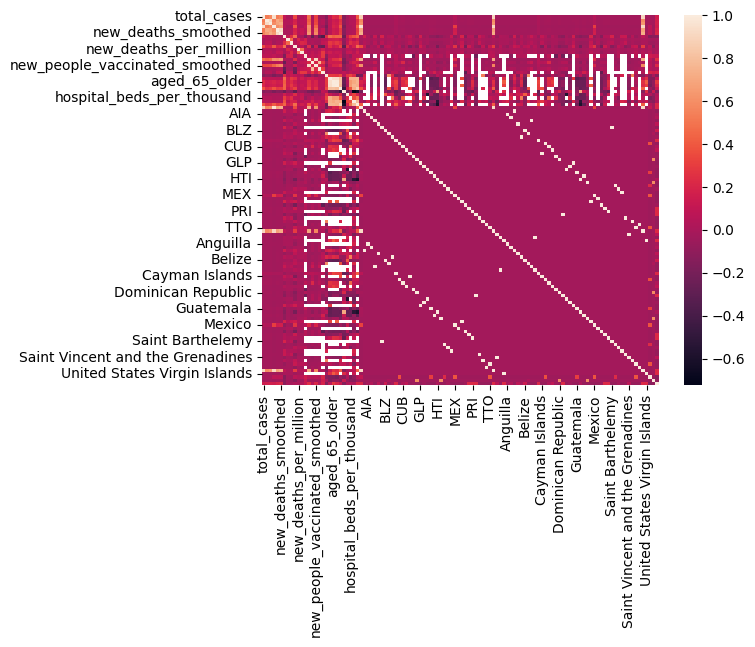

In [153]:
sns.heatmap(corr)

Compare the correlation between features and remove one of two features that have a correlation higher than 0.9:

In [154]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = df_training_corr.columns[columns]
selected_columns.shape

(65,)

In [155]:
show_items_in_table(
    f"A total of {selected_columns.shape[0]} columns were selected:",
    selected_columns, 5)

A total of 65 columns were selected:
| | | | | |
| :--- | :--- | :--- | :--- | :--- |
|`total_cases` | `new_cases` | `new_deaths` | `total_cases_per_million` | `new_cases_per_million` |
|`new_cases_smoothed_per_million` | `total_deaths_per_million` | `new_deaths_per_million` | `new_deaths_smoothed_per_million` | `reproduction_rate` |
|`new_vaccinations_smoothed` | `new_vaccinations_smoothed_per_million` | `new_people_vaccinated_smoothed_per_hundred` | `stringency_index` | `population_density` |
|`median_age` | `gdp_per_capita` | `cardiovasc_death_rate` | `diabetes_prevalence` | `hospital_beds_per_thousand` |
|`life_expectancy` | `human_development_index` | `ABW` | `AIA` | `ATG` |
|`BES` | `BHS` | `BLM` | `BLZ` | `BMU` |
|`BRB` | `CAN` | `CRI` | `CUB` | `CUW` |
|`CYM` | `DMA` | `DOM` | `GLP` | `GRD` |
|`GRL` | `GTM` | `HND` | `HTI` | `JAM` |
|`KNA` | `LCA` | `MAF` | `MEX` | `MSR` |
|`MTQ` | `NIC` | `PAN` | `PRI` | `SLV` |
|`SPM` | `SXM` | `TCA` | `TTO` | `VCT` |
|`VGB` | `VIR` | `people tested` | `samples tested` | `tests performed` |


In [156]:
df_training_corr_before = df_training_corr

# The dataset has only those columns with correlation less than 0.9
df_training_corr = df_training_corr[selected_columns]

df_details(
    "Removing columns with correlation > 0.9",
    {
        "Before": df_training_corr_before,
        "After": df_training_corr
    })

| Removing columns with correlation > 0.9 | Before | After |
| :--- | ---: | ---: |
| Number of observations | 29930 | 29930 |
| Number of attributes | 114 | 65 |
| Size | 3412020 | 1945450 |

In [157]:
df_training_corr.head()

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,...,SPM,SXM,TCA,TTO,VCT,VGB,VIR,people tested,samples tested,tests performed
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,13,0.0,0.0,818.794,0.000,17.995,NaN,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02,14,1.0,0.0,881.779,62.984,26.993,NaN,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-03,15,1.0,0.0,944.763,62.984,26.993,NaN,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-04,15,0.0,0.0,944.763,0.000,26.993,NaN,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,15,0.0,0.0,944.763,0.000,17.995,NaN,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Selecting columns based on p-value

Next select the columns based on how they affect the p-value. Remove the column total_cases because it is the column we are trying to predict

In [158]:
# Removing the total_cases column
selected_columns = selected_columns.drop('total_cases')
show_items_in_table(None, selected_columns, 5)


| | | | | |
| :--- | :--- | :--- | :--- | :--- |
|`new_cases` | `new_deaths` | `total_cases_per_million` | `new_cases_per_million` | `new_cases_smoothed_per_million` |
|`total_deaths_per_million` | `new_deaths_per_million` | `new_deaths_smoothed_per_million` | `reproduction_rate` | `new_vaccinations_smoothed` |
|`new_vaccinations_smoothed_per_million` | `new_people_vaccinated_smoothed_per_hundred` | `stringency_index` | `population_density` | `median_age` |
|`gdp_per_capita` | `cardiovasc_death_rate` | `diabetes_prevalence` | `hospital_beds_per_thousand` | `life_expectancy` |
|`human_development_index` | `ABW` | `AIA` | `ATG` | `BES` |
|`BHS` | `BLM` | `BLZ` | `BMU` | `BRB` |
|`CAN` | `CRI` | `CUB` | `CUW` | `CYM` |
|`DMA` | `DOM` | `GLP` | `GRD` | `GRL` |
|`GTM` | `HND` | `HTI` | `JAM` | `KNA` |
|`LCA` | `MAF` | `MEX` | `MSR` | `MTQ` |
|`NIC` | `PAN` | `PRI` | `SLV` | `SPM` |
|`SXM` | `TCA` | `TTO` | `VCT` | `VGB` |
|`VIR` | `people tested` | `samples tested` | `tests performed` | |


#### Backward Elimination

Take care of missing values encoded as NaN natively by replacing with the mean:

In [159]:
for c in df_training_corr.columns:
    df_training_corr[c] = df_training_corr[c].\
        fillna(df_training_corr[c].mean())

In [160]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    # x=np.array(x, dtype=float)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).\
            astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
    return x, columns, regressor_OLS.summary()

In [161]:
SL = 0.05

col = 'total_cases'
df_training_corr["total_cases"] = df_training_corr["total_cases"].\
    astype("int32")
data_modeled, selected_columns, summary = backwardElimination(
    df_training_corr.loc[:, df_training_corr.columns != col].values,
    df_training_corr.loc[:, df_training_corr.columns == col].values,
    SL,
    selected_columns)

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     6744.
Date:                Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:57:06   Log-Likelihood:            -4.8789e+05
No. Observations:               29930   AIC:                         9.759e+05
Df Residuals:                   29878   BIC:                         9.763e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            26.5283      0.855     31.016      0.000      24.852      28.205
x2         -8636.0317    124.555    -69.335      0.000   -8880.165   -8391.898
x3             1.0153      0.210      4.827      0.000       0.603       1.428
x4           676.7880     42.996     15.741      0.000     592.513     761.063
x5           -18.3752      0.137   -134.466      0.000     -18.643     -18.107
x6           208.9172     10.811     19.325      0.000     187.728     230.107
x7         -1.173e+06    1.8e+05     -6.519      0.000   -1.53e+06    -8.2e+05
x8         -9365.6215   1416.334     -6.613      0.000   -1.21e+04   -6589.546
x9         -5.154e+04    134.508   -383.208      0.000   -5.18e+04   -5.13e+04
x10        -7.632e+05   5027.904   -151.794      0.000   -7.73e+05   -7.53e+05
x11         2121.0152      5.096    416.198      0.000    2111.026    2131.004
x12         8.522e+04    384.758    221.486      0.000    8.45e+04     8.6e+04
x13         4.879e+05   8161.489     59.779      0.000    4.72e+05    5.04e+05
x14         -1.05e+05   2.03e+04     -5.186      0.000   -1.45e+05   -6.53e+04
x15        -4.103e+05   2621.719   -156.503      0.000   -4.15e+05   -4.05e+05
x16         1.424e+07   5.35e+04    266.042      0.000    1.41e+07    1.43e+07
x17        -1.757e+07   1.08e+05   -162.639      0.000   -1.78e+07   -1.74e+07
x18        -4.867e+06   1.08e+05    -45.029      0.000   -5.08e+06   -4.65e+06
x19        -1.109e+07   1.04e+05   -106.807      0.000   -1.13e+07   -1.09e+07
x20        -6.449e+06   1.11e+05    -57.846      0.000   -6.67e+06   -6.23e+06
x21        -3.818e+07   1.35e+05   -283.608      0.000   -3.84e+07   -3.79e+07
x22        -6.042e+06   1.21e+05    -50.037      0.000   -6.28e+06   -5.81e+06
x23         5.268e+05   9.52e+04      5.536      0.000     3.4e+05    7.13e+05
x24        -1.003e+07    8.3e+04   -120.911      0.000   -1.02e+07   -9.87e+06
x25         2.871e+07   1.07e+05    268.603      0.000    2.85e+07    2.89e+07
x26        -4.775e+07   1.56e+05   -305.819      0.000   -4.81e+07   -4.74e+07
x27         2.059e+06   1.16e+05     17.705      0.000    1.83e+06    2.29e+06
x28        -4.512e+06    9.4e+04    -47.998      0.000    -4.7e+06   -4.33e+06
x29         3.953e+06   1.02e+05     38.758      0.000    3.75e+06    4.15e+06
x30        -6.641e+07   2.05e+05   -323.658      0.000   -6.68e+07    -6.6e+07
x31         5.821e+06   1.02e+05     57.313      0.000    5.62e+06    6.02e+06
x32        -5.046e+06    1.5e+05    -33.573      0.000   -5.34e+06   -4.75e+06
x33          2.38e+06   1.03e+05     23.144      0.000    2.18e+06    2.58e+06
x34         2.535e+06   1.01e+05     25.038      0.000    2.34e+06    2.73e+06
x35        -1.948e+07   1.01e+05   -192.202      0.000   -1.97e+07   -1.93e+07
x36         1.292e+07   1.14e+05    113.709      0.000    1.27e+07    1.31e+07
x3

Moving the results to a new dataframe

In [162]:
result = pd.DataFrame()
result['total_cases'] = df_training_corr.loc[
    :, df_training_corr.columns == col]

# result.head()
# result.tail()

result = result.reset_index(drop=True)

# result.head()
# result.tail()

Creating a dataframe with the columns selected using the p-value and correlation

In [163]:
df_training_corr_p_value = pd.DataFrame(
    data=data_modeled,
    columns=selected_columns)

# Also need a dataset that combine both predictive column
# 'total_cases; and selected columns
df_corr_p_value = pd.concat([
    df_training_corr_p_value,
    result
    ], axis=1)

df_details(None, {
    "After creating a dataframe with the  columns selected using " +
    "the p-value and correlation": df_corr_p_value})

# df_corr_p_value.head()
# df_training_corr.head()
# result.head()
# df_training_corr_p_value.head()

|  | After creating a dataframe with the  columns selected using the p-value and correlation |
| :--- | ---: |
| Number of observations | 29930 |
| Number of attributes | 60 |
| Size | 1795800 |

##### Visualize the selected features

Plot the data to visualize the distribution of the features. TODO

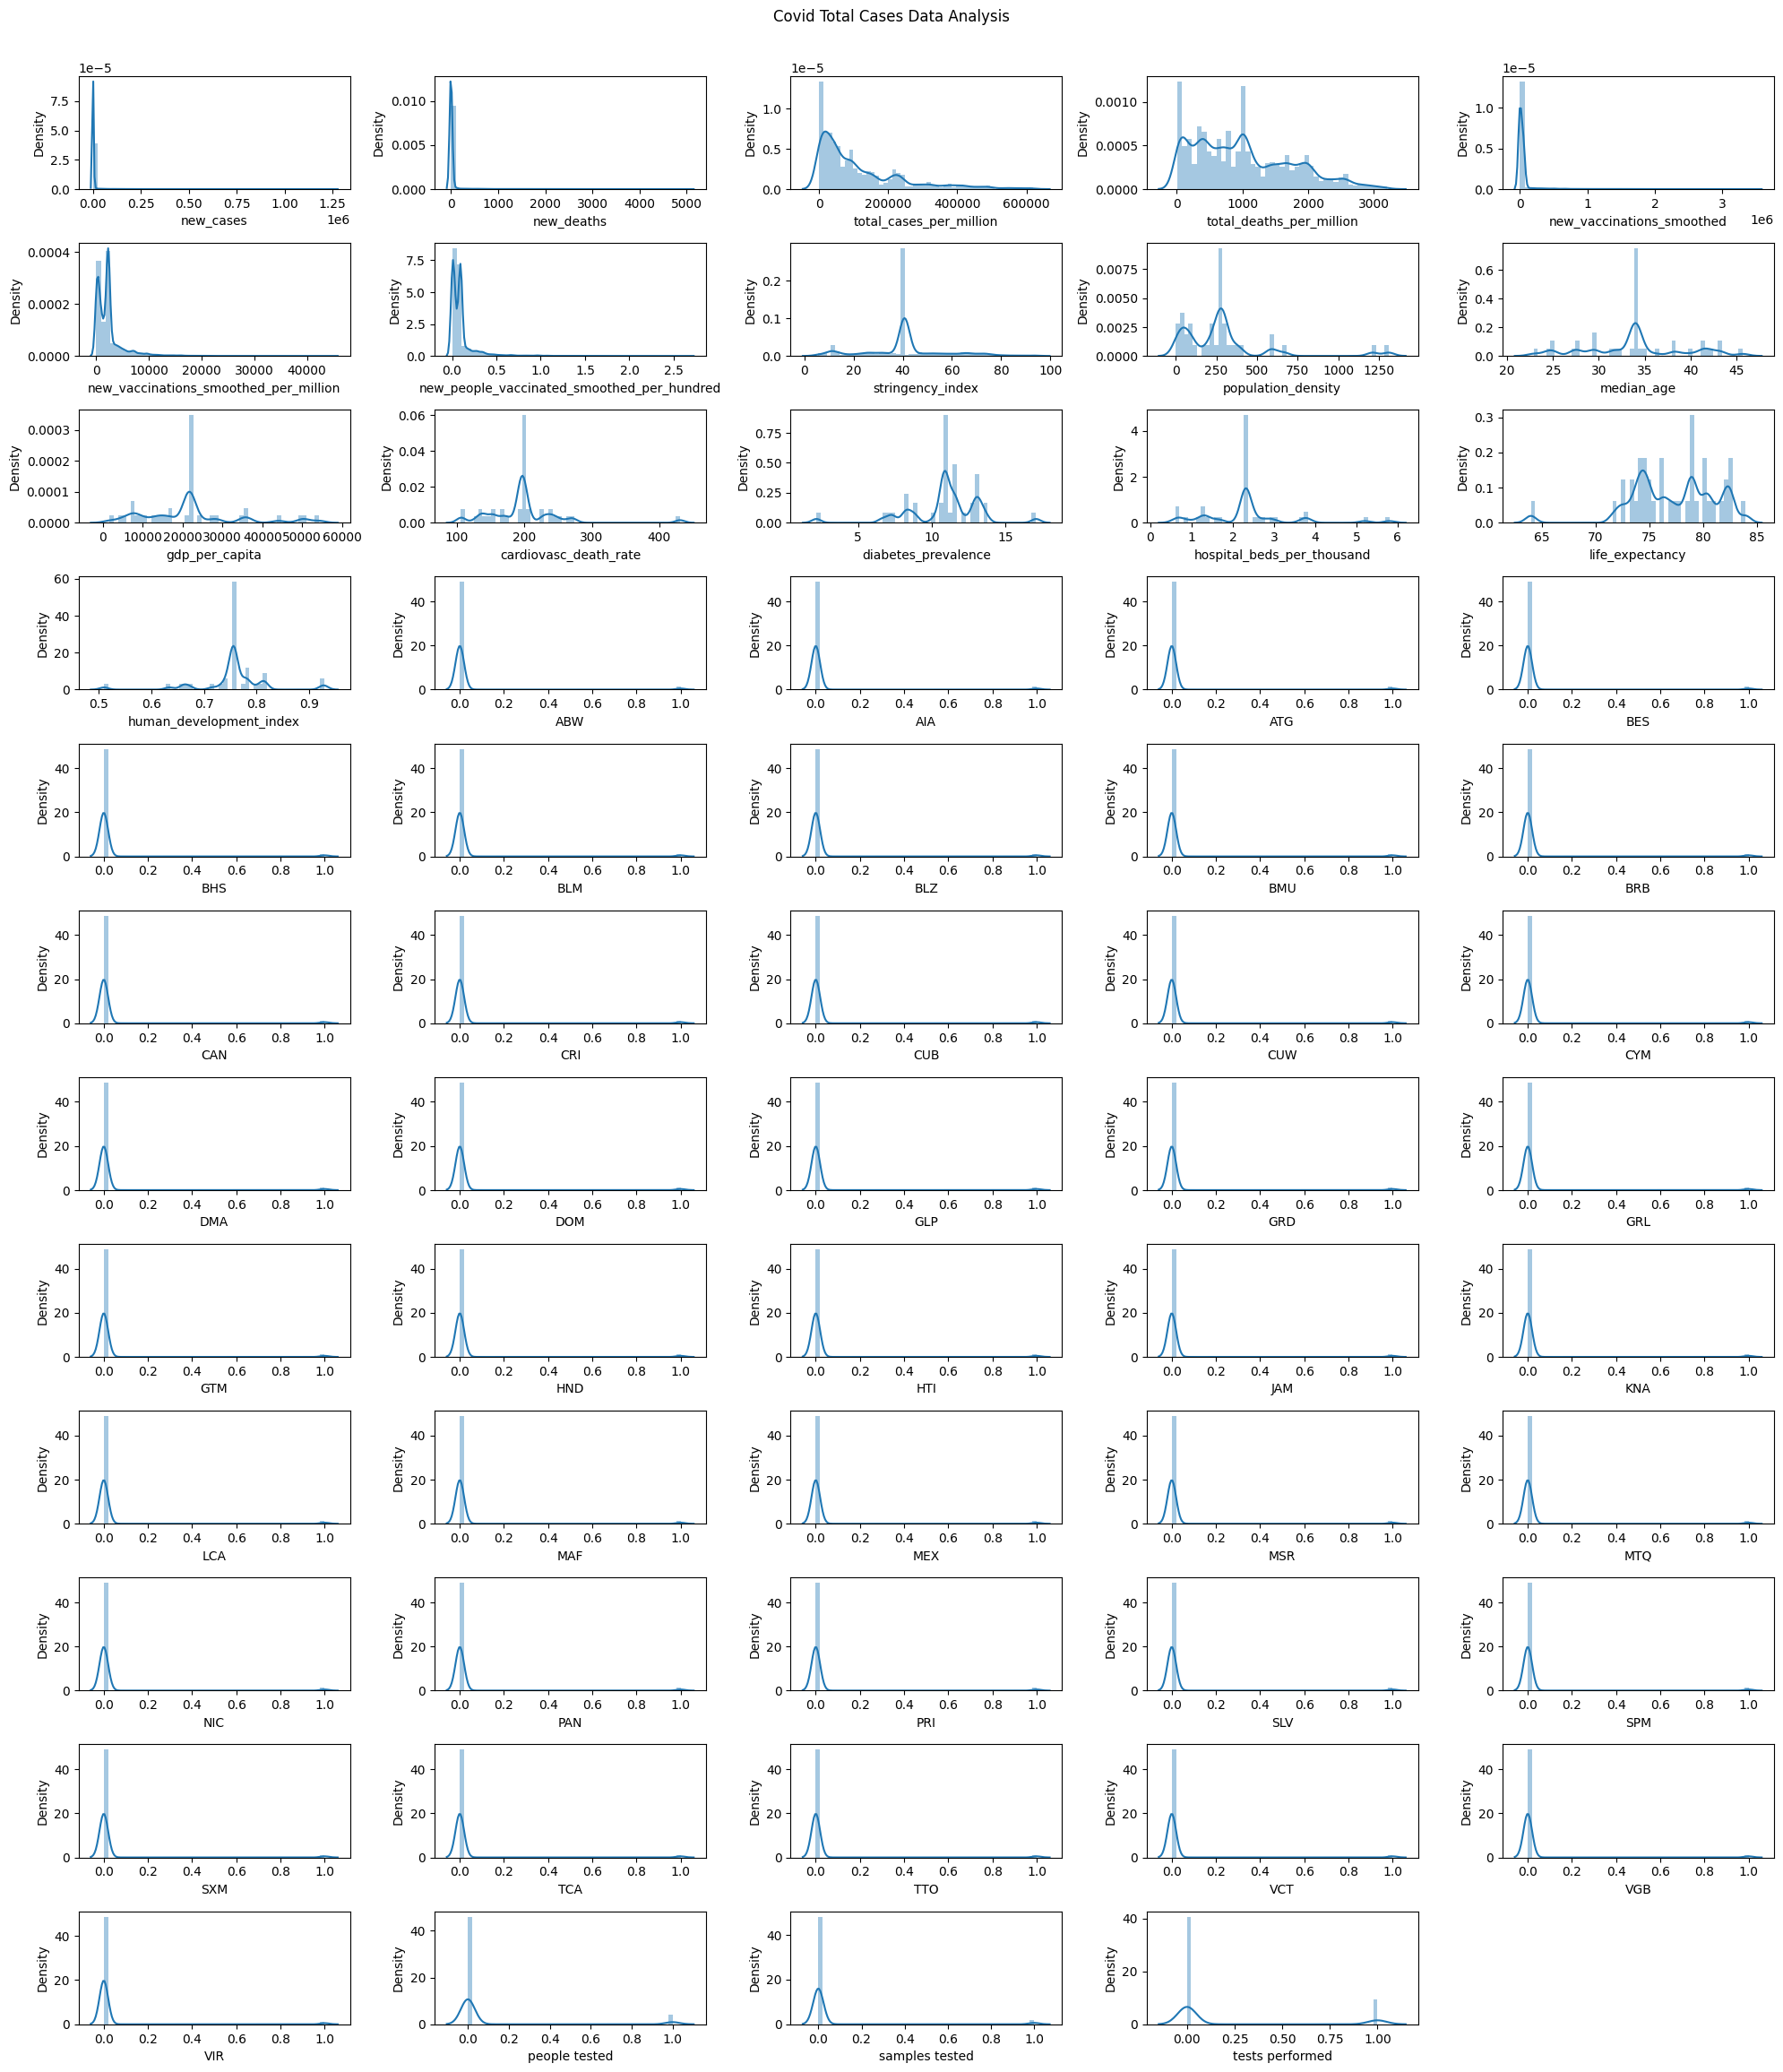

INFO:pycodestyle:12:11: E703 statement ends with a semicolon


In [164]:
fig = plt.figure(figsize=(20, 25))
j = 0
for i in df_training_corr_p_value.columns:
    plt.subplot(13, 5, j+1)
    j += 1
    sns.distplot(df_training_corr_p_value[i])
    # plt.legend(loc='best',fontsize=10)
fig.suptitle('Covid Total Cases Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show();

In [165]:
df_corr_p_value.head()
df_corr_p_value.tail()

,new_cases,new_deaths,total_cases_per_million,total_deaths_per_million,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,...,SXM,TCA,TTO,VCT,VGB,VIR,people tested,samples tested,tests performed,total_cases
0,0.0,0.0,818.794,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,33.974074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
1,1.0,0.0,881.779,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,33.974074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
2,1.0,0.0,944.763,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,33.974074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
3,0.0,0.0,944.763,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,33.974074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
4,0.0,0.0,944.763,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,33.974074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15


,new_cases,new_deaths,total_cases_per_million,total_deaths_per_million,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,...,SXM,TCA,TTO,VCT,VGB,VIR,people tested,samples tested,tests performed,total_cases
29925,0.0,0.0,238583.018,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,42.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23734
29926,0.0,0.0,238583.018,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,42.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23734
29927,30.0,0.0,238884.589,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,42.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23764
29928,0.0,0.0,238884.589,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,42.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23764
29929,5.0,0.0,238934.851,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,42.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23769


### Low Variance Filter

Another way of measuring how much information a data column has is to measure its variance. In the limit case where the column cells assume a constant value, the variance would be 0 and the column would be of no help in the discrimination of different groups of data.

The Low Variance Filter node TODO calculates each column variance and removes those columns with a variance value below a given threshold. Notice that the variance can only be calculated for numerical columns, i.e. this dimensionality reduction method applies only to numerical columns. Note, too, that the variance value depends on the column numerical range. Therefore data column ranges need to be normalized to make variance values independent from the column domain range.

In [166]:
# The default value for the threshold is always 0.
vt = VarianceThreshold()

# For now, I will subset the numeric features into another dataframe:
X_train_num = df_corr_p_value.select_dtypes(include="number")
# X_train_num.shape
# X_train_num.info()

Evaluate the effect of different variance thresholds.

>Threshold=0.00, Features=60
>Threshold=0.05, Features=17
>Threshold=0.10, Features=16
>Threshold=0.15, Features=16
>Threshold=0.20, Features=15


>Threshold=0.25, Features=15
>Threshold=0.30, Features=15
>Threshold=0.35, Features=15
>Threshold=0.40, Features=15
>Threshold=0.45, Features=15
>Threshold=0.50, Features=15
>Threshold=0.55, Features=15
>Threshold=0.60, Features=15
>Threshold=0.65, Features=15
>Threshold=0.70, Features=15
>Threshold=0.75, Features=15
>Threshold=0.80, Features=15
>Threshold=0.85, Features=15
>Threshold=0.90, Features=15
>Threshold=0.95, Features=15
>Threshold=1.00, Features=15


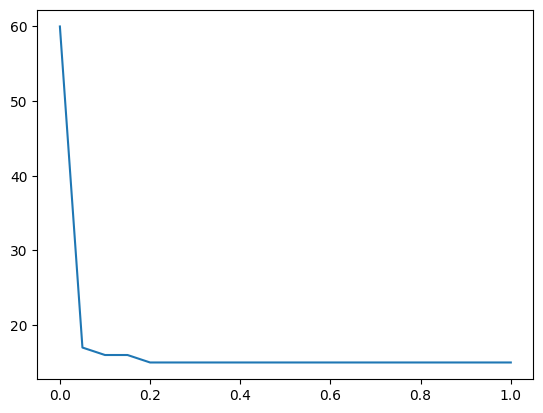

INFO:pycodestyle:19:11: E703 statement ends with a semicolon


In [167]:
thresholds = np.arange(0.0, 1.05, 0.05)

# apply transform with each threshold
results = list()
for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_sel = transform.fit_transform(X_train_num)
    # determine the number of input features
    n_features = X_sel.shape[1]
    print(">Threshold=%.2f, Features=%d" % (t, n_features))
    # store the result
    results.append(n_features)
    # print(X_sel.dtype)

# plot the threshold vs the number of selected features
plt.plot(thresholds, results)
plt.show();

The line pot shows the relationship between the threshold and the number of features in the transformed dataset. I can see that with a small threshold of 0.10, 3 features are removed immediately.

First, we fit the estimator to data and call its `get_support()` method. It returns a boolean mask with `True` values for columns which are not dropped.

We can then use this mask to subset our DataFrame like so:

In [168]:
_ = vt.fit(X_train_num)
mask = vt.get_support()

X_train_num = X_train_num.loc[:, mask]

# Let’s drop features with variances close to 0
vt = VarianceThreshold(threshold=1)

# Fit
_ = vt.fit(X_train_num)

# # Get the boolean mask
mask = vt.get_support()

X_train_LowVariance = X_train_num.loc[:, mask]

df_details(None, {
    "After dropping features with variances close to 0": X_train_LowVariance}
    )

X_train_LowVariance.info()

|  | After dropping features with variances close to 0 |
| :--- | ---: |
| Number of observations | 29930 |
| Number of attributes | 15 |
| Size | 448950 |

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29930 entries, 0 to 29929
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   new_cases                              29930 non-null  float64
 1   new_deaths                             29930 non-null  float64
 2   total_cases_per_million                29930 non-null  float64
 3   total_deaths_per_million               29930 non-null  float64
 4   new_vaccinations_smoothed              29930 non-null  float64
 5   new_vaccinations_smoothed_per_million  29930 non-null  float64
 6   stringency_index                       29930 non-null  float64
 7   population_density                     29930 non-null  float64
 8   median_age                             29930 non-null  float64
 9   gdp_per_capita                         29930 non-null  float64
 10  cardiovasc_death_rate                  29930 non-null  float64
 11  di

# Generate Profiling Report
Data profiling is report is available in GitHub: [CIND820_EDA_DataProfiling.html](https://github.com/aamadorc/CIND820/blob/main/CIND820_EDA_DataProfiling.html)/[CIND820_EDA_DataProfiling.ipynb](https://github.com/aamadorc/CIND820/blob/main/CIND820_EDA_DataProfiling.ipynb).

In [169]:
# Generate profiling report
# profile = ProfileReport(
#     data, title="Profiling Report", 
#     html={'style':{'fullwith':True}}
# )
# profile

INFO:pycodestyle:3:38: W291 trailing whitespace


# Modeling

Prepare the Train and Test datasets:

In [170]:
train_dataset = X_train_LowVariance
test_dataset = df_test[X_train_LowVariance.columns]

# train_dataset.columns
# test_dataset.columns

Testing dataset has to be a complete dataset, then any NaN on testing dataset needs to be moved to the training dataset:

In [171]:
train_dataset.shape
test_dataset.shape
# df_details(None, {"Training data set": df_training})

describe_nan(train_dataset)
describe_nan(test_dataset)

# test_dataset.isna().shape
# test_dataset[test_dataset.isnull().any(axis=1)].shape

(29930, 15)

(11357, 15)

,column,nan_count,nan_rate
0,new_cases,0,0.0
1,new_deaths,0,0.0
2,total_cases_per_million,0,0.0
3,total_deaths_per_million,0,0.0
4,new_vaccinations_smoothed,0,0.0
5,new_vaccinations_smoothed_per_million,0,0.0
6,stringency_index,0,0.0
7,population_density,0,0.0
8,median_age,0,0.0
9,gdp_per_capita,0,0.0


,column,nan_count,nan_rate
0,new_cases,137,0.012063
1,new_deaths,138,0.012151
2,total_cases_per_million,0,0.000000
3,total_deaths_per_million,0,0.000000
4,new_vaccinations_smoothed,8278,0.728890
5,new_vaccinations_smoothed_per_million,8278,0.728890
6,stringency_index,11357,1.000000
7,population_density,1939,0.170732
8,median_age,3878,0.341463
9,gdp_per_capita,3878,0.341463


Unfortunately, any record in testing dataset has NaN records. `stringency_index` is completed NaN. TODO

To be able to run the models, I am going to replace NaN values by the mean value of the corresponding column.

In [172]:
for c in test_dataset.columns:
    test_dataset[c] = test_dataset[c].fillna(test_dataset[c].mean())

`stringency_index` doesn't have any information in 2023, because no longer we have restrictions. Then I will remove it from the datasets.

In [173]:
show_items_in_table(None, train_dataset.columns, 6)

train_dataset.drop(columns="stringency_index", inplace=True)
test_dataset.drop(columns="stringency_index", inplace=True)


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
|`new_cases` | `new_deaths` | `total_cases_per_million` | `total_deaths_per_million` | `new_vaccinations_smoothed` | `new_vaccinations_smoothed_per_million` |
|`stringency_index` | `population_density` | `median_age` | `gdp_per_capita` | `cardiovasc_death_rate` | `diabetes_prevalence` |
|`hospital_beds_per_thousand` | `life_expectancy` | `total_cases` | | | |


Initiate variables for running models

In [174]:
# Predictive variable
col = 'total_cases'

X_train = train_dataset.loc[:, train_dataset.columns != col]
X_test = test_dataset.loc[:, test_dataset.columns != col]
y_train = train_dataset.loc[:, train_dataset.columns == col]
y_test = test_dataset.loc[:, test_dataset.columns == col]

# convert pandas dataframes to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Linear Regression
Create a model and fit it

In [175]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [176]:
# Test
accuracy = lr.score(X_test, y_test)
display(Markdown("> Accuracy of Linear Regression: %s" % accuracy))

> Accuracy of Linear Regression: 0.2900476475462085

In [177]:
# Predict using our Model
pred = lr.predict(X_test)
print(pred)
display(Markdown(str(pred)))

[[-687860.09064519]
 [-687860.09064519]
 [-687860.09064519]
 ...
 [  52267.29956995]
 [  52267.29956995]
 [  52267.29956995]]


[[-687860.09064519]
 [-687860.09064519]
 [-687860.09064519]
 ...
 [  52267.29956995]
 [  52267.29956995]
 [  52267.29956995]]

Evaluate the model:

In [178]:
display(Markdown("> Intercept: %s" % lr.intercept_))
display(Markdown("> Slope: %s" % lr.coef_))

> Intercept: [17749347.46536455]

> Slope: [[ 9.37270945e+01  3.80709553e+03 -1.02060427e+00  2.87992075e+03
   8.75314502e+00 -1.97713171e+02 -7.34347178e+03 -1.63499797e+05
   3.13749163e+02  6.50732559e+03 -1.21399992e+05  2.96266913e+05
  -2.46479925e+05]]